1.Importing Libraries

In [5]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
import cv2

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import backend as K

2.Loading Dataset

In [2]:
#  input to DenseNet121 is 224x224 with rgb, batch_size=32
IMAGE_SIZE=[224,224]
BATCH_SIZE=32

In [3]:
train_path='F:\\project\\Neurodegen\\Dataset\\Alz-DS\\data\\train'
test_path='F:\\project\\Neurodegen\\Dataset\\Alz-DS\\data\\test'

Dataset Visualization

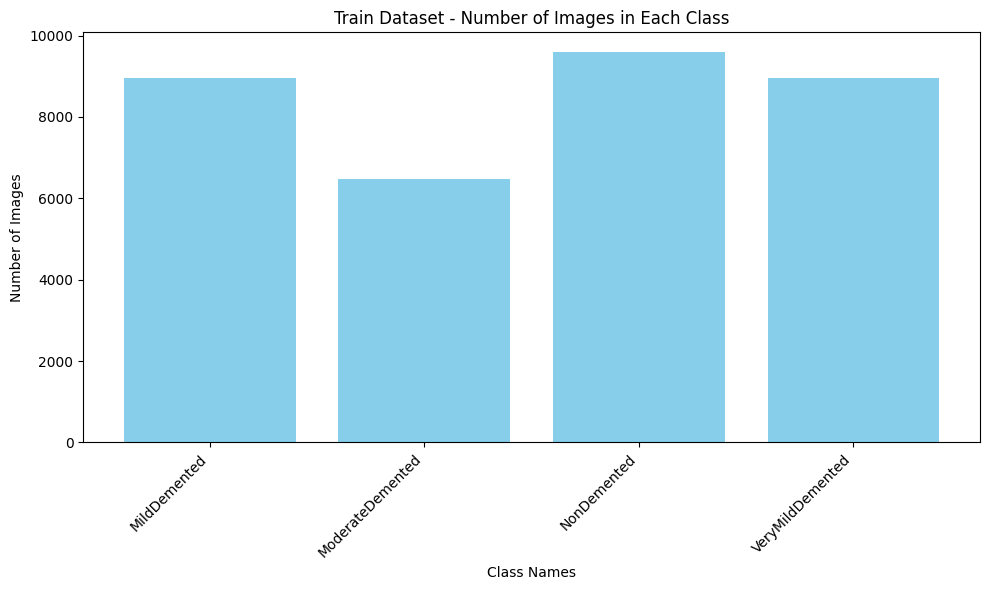

In [22]:
# Path to your dataset directory
dataset_directory = train_path

# List class names (subdirectories in the dataset directory)
class_names = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

# Count the number of images in each class
class_image_counts = []

for class_name in class_names:
    class_dir = os.path.join(dataset_directory, class_name)
    num_images = len(os.listdir(class_dir))  # Count the number of images in the class directory
    class_image_counts.append(num_images)

# Plot the number of images in each class as a bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_image_counts, color='skyblue')

# Add labels and title
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Train Dataset - Number of Images in Each Class')
plt.xticks(rotation=45, ha='right')  # Rotate class names for better visibility

# Show the plot
plt.tight_layout()
plt.show()


Importing DenseNet121 and adding preprocessing layers

In [7]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE + [3])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
for layers in base_model.layers:
  print(layers)

<InputLayer name=input_layer, built=True>
<ZeroPadding2D name=zero_padding2d, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=zero_padding2d_1, built=True>
<MaxPooling2D name=pool1, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<Activation name=conv2_block1_0_relu, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<Concatenate name=conv2_block1_concat, built=True>
<BatchNormalization name=conv2_block2_0_bn, built=True>
<Activation name=conv2_block2_0_relu, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Activation name=conv2_block2_1_relu, built=True>
<Conv2D name=conv2_block2_2_conv, built=True>
<Concatenate name=conv2_block2_concat,

In [27]:
for layer in base_model.layers:
  layer.trainable=False

In [28]:
for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_layer False
zero_padding2d False
conv1_conv False
conv1_bn False
conv1_relu False
zero_padding2d_1 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_

DenseNet121 model Summary

In [11]:
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

Building the Final Model

In [12]:
model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(4,activation='softmax'))

Structure Of the final Model

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,730,180 (124.86 MB)

 Trainable params: 25,692,676 (98.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Specifying the Cost and Optimization Methods

In [26]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Using the Image Data Generator to import images from the Dataset

In [19]:
train_datagen= ImageDataGenerator(
    rescale=1./255,
    shear_range =0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
training_set=train_datagen.flow_from_directory(train_path,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')


Found 33984 images belonging to 4 classes.


In [21]:
test_set=test_datagen.flow_from_directory( test_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 6400 images belonging to 4 classes.


Model Fitting

In [29]:
history= model.fit(
    training_set,
    validation_data=test_set,
    epochs=15,
    steps_per_epoch=len(training_set) // BATCH_SIZE,
    validation_steps=len(test_set) // BATCH_SIZE
)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4138 - loss: 8.5008 - val_accuracy: 0.5208 - val_loss: 1.4948
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5489 - loss: 1.6922 - val_accuracy: 0.5469 - val_loss: 1.4735
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6379 - loss: 1.1476 - val_accuracy: 0.5990 - val_loss: 0.8671
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.6261 - loss: 0.9882 - val_accuracy: 0.5521 - val_loss: 1.3751
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.5988 - loss: 1.4002 - val_accuracy: 0.6302 - val_loss: 1.3611
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.6598 - loss: 1.2226 - val_accuracy: 0.5000 - val_loss: 2.2683
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.6430 - loss: 1.0543 - val_accuracy: 0.6719 - val_loss: 0.8796
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.6614 - loss: 0.8616 - val_accuracy: 0.7396 - val_loss:

Fine Tuning DenseNet121 Model

In [31]:
# Unfreeze the last few layers of the base model
for layer in model.layers[-30:]:
    layer.trainable = True

for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_layer False
zero_padding2d False
conv1_conv False
conv1_bn False
conv1_relu False
zero_padding2d_1 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_

In [32]:
# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
# Continue training the model with unfrozen layers
history_finetune = model.fit(training_set,
                             validation_data=test_set,
                             epochs=10,
                             steps_per_epoch=len(training_set) // BATCH_SIZE,
                             validation_steps=len(test_set) // BATCH_SIZE)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7502 - loss: 0.5821 - val_accuracy: 0.7031 - val_loss: 0.6981
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7763 - loss: 0.5346 - val_accuracy: 0.7552 - val_loss: 0.6150
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7809 - loss: 0.5433 - val_accuracy: 0.6302 - val_loss: 0.7515
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7656 - loss: 0.5521 - val_accuracy: 0.7031 - val_loss: 0.6102
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1053s 33s/step - accuracy: 0.7827 - loss: 0.5500 - val_accuracy: 0.7500 - val_loss: 0.6147
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7528 - loss: 0.5578 - val_accuracy: 0.7031 - val_loss: 0.5885
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7679 - loss: 0.5508 - val_accuracy: 0.6562 - val_loss: 0.6920
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7383 - loss: 0.6026 - val_accuracy: 0.6719 - val_lo